In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt

### Conclusions

I have implemented the test function for accuracy and loss. I experimented with BatchNorm2d and Dropout layers, and here are the results:


#### Default model

The accuracy is good- 97% on test set

#### 1. BatchNorm2d

With BatchNorm2d layer the training happened a lot faster. For example:

Without BatchNorm2d layer after first epoch: train loss- 0.0181, test loss- 0.011

With BatchNorm2d layer after first epoch:    train loss- 0.0127, test loss- 0.0076

Also the accuracy with BatchNorm2d layer was a bit higher. 97.7%-- the accuracy for batchNorm if I place the batchnorm layer after first Conv layer


#### 1. Dropout

With Dropout regularization layer I managed to get worse results.

Without Dropout layer, 20 epochs
[0.9664, 0.975, 0.9754, 0.9816, 0.9794, 0.9808, 0.9799, 0.981, 0.9811, 0.9803, 0.9815, 0.9828, 0.9815, 0.9825, 0.9799, 0.9827, 0.9838, 0.9836, 0.983, 0.9781]

With Dropout layer, 20 epochs
[96.3, 96.2, 96.7, 96.6, 97.0, 96.8, 97.1, 97.0, 97.0, 97.1, 97.2, 97.0, 97.2, 97.4, 97.1, 97.1, 97.0, 96.6, 97.2]

I assume that the problem is that our network is too shallow for Dropout here. Dropout somehow only damages the performance of the network. We can also see how our network start to overfit without the dropout

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
class MnistNet(nn.Module):
    """
    Liteweight network architecture for the Mnist dataset (digit) classification
    """
    def __init__(self, dropout=False):
        super(MnistNet, self).__init__()
        self.num_classes = 10
        
        if dropout:
            # fully convolutional part
            self.features = nn.Sequential(
                nn.Conv2d(1, 4, kernel_size=5),
                nn.BatchNorm2d(4),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1),
                nn.Conv2d(4, 4, kernel_size=5),
                nn.BatchNorm2d(4),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1)
            )
            
        else:
            # fully convolutional part
            self.features = nn.Sequential(
                nn.Conv2d(1, 4, kernel_size=5),
                nn.BatchNorm2d(4),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(inplace=True),
                nn.Conv2d(4, 4, kernel_size=5),
                nn.BatchNorm2d(4),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(inplace=True)            
            )
        if dropout:
            self.classifier = nn.Sequential(
                nn.Linear(16*4,16),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.2),
                nn.Linear(16,self.num_classes)
            )
        else:
            # classifier, FC layers
            self.classifier = nn.Sequential(
                nn.Linear(16*4,16),
                nn.ReLU(inplace=True),
                nn.Linear(16,self.num_classes)
            )
        
    def forward(self, x):
        x = x.to(device)

        x = self.features(x)
        x = self.classifier(x.view(-1,x.size(-3)*x.size(-2)*x.size(-1)))
        return x


def train(model, train_loader, optimizer):
    """
    Training of an epoch
    model: network
    train_loader: train_loader loading images and labels in batches
    optimizer: optimizer to use in the training
    """
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the accumulated gradients
        output = model(data) # computer network's output

        loss = F.cross_entropy(output, target) # computer the loss


        loss.backward() # backward pass
        optimizer.step() # update weights
        
        total_loss = total_loss + loss.item()
        
        if batch_idx % 1000 == 0:
            print('[{}/{} ({:.0f}%)]\tBatch loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()/len(data)))
    
    print('Training: Epoch average loss {:.6f}'.format(total_loss/len(train_loader.dataset)))
         
        
def test(model, val_loader):
    """
    Compute accuracy on the validation set
    model: network
    val_loader: test_loader loading images and labels in batches
    """
    model.eval()
    
    # implement validation procedure, report accuracy on the validation set
    
    batches = len(val_loader)
    size = len(val_loader.dataset)
    batches, size

    with torch.no_grad():
        loss_sum, accuracy = 0, 0
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            predictions = model(X)
            loss = F.cross_entropy(predictions, y).item()
            loss_sum += loss

            accuracy += (predictions.argmax(1) == y).type(torch.float).sum().item()

    loss /= batches
    accuracy /= size
    return loss, accuracy


Sample images


C:\Users\m84200118\Anaconda3\envs\v-env\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


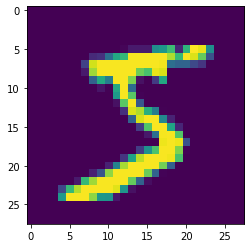

In [5]:
# mnist dataset structure - train part
mnist_dataset_train = datasets.MNIST('vs3ex1data/mnist_data', train=True, download=True, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ]))
# mnist dataset structure - test part
mnist_dataset_val = datasets.MNIST('vs3ex1data/mnist_data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ]))

# show sample images
print('Sample images')
for i in range(0,100,100):
    plt.imshow(Image.fromarray(mnist_dataset_train.train_data[i].numpy(), mode='L'))
    plt.show()

In [6]:
# loader of the training set
train_loader = torch.utils.data.DataLoader(mnist_dataset_train,batch_size=16, shuffle=True)
# loader of the validation set
val_loader = torch.utils.data.DataLoader(mnist_dataset_val,batch_size=512, shuffle=False)


In [43]:
model_no_dropout = MnistNet() # initialize network structure

optimizer = optim.SGD(model_no_dropout.parameters(), lr=0.01, momentum=0.9)

# loss, accuracy = test(model, val_loader)
# print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f} \n")

loss_history = []
accuracy_hostory = []

for epoch in range(1, 21):
        print('Epoch {}'.format(epoch))
        train(model_no_dropout, train_loader, optimizer)
        loss, accuracy = test(model_no_dropout, val_loader)
        loss_history.append(loss)
        accuracy_hostory.append(accuracy)
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f} \n")


Epoch 1
[0/60000 (0%)]	Batch loss: 0.149664
[16000/60000 (27%)]	Batch loss: 0.005944
[32000/60000 (53%)]	Batch loss: 0.000788
[48000/60000 (80%)]	Batch loss: 0.004036
Training: Epoch average loss 0.012215
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.010640 

Epoch 2
[0/60000 (0%)]	Batch loss: 0.000170
[16000/60000 (27%)]	Batch loss: 0.004268
[32000/60000 (53%)]	Batch loss: 0.000281
[48000/60000 (80%)]	Batch loss: 0.001623
Training: Epoch average loss 0.005902
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.004933 

Epoch 3
[0/60000 (0%)]	Batch loss: 0.000315
[16000/60000 (27%)]	Batch loss: 0.003874
[32000/60000 (53%)]	Batch loss: 0.019031
[48000/60000 (80%)]	Batch loss: 0.004662
Training: Epoch average loss 0.005086
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.010060 

Epoch 4
[0/60000 (0%)]	Batch loss: 0.002215
[16000/60000 (27%)]	Batch loss: 0.000539
[32000/60000 (53%)]	Batch loss: 0.000756
[48000/60000 (80%)]	Batch loss: 0.000550
Training: Epoch average loss 0.004650
Test Error: 
 Accuracy: 

In [44]:
print(loss_history)
print(accuracy_hostory)

[0.010640297085046768, 0.004933014884591103, 0.010060443729162215, 0.006587996333837509, 0.005448458716273308, 0.006656131148338318, 0.004548512771725655, 0.006845234334468842, 0.006202542781829834, 0.008441054075956345, 0.005890649184584618, 0.006258149445056915, 0.005286131426692009, 0.006665366888046265, 0.005813745409250259, 0.005224801599979401, 0.005987083166837692, 0.005067266523838043, 0.005265174806118012, 0.006095708906650543]
[0.9706, 0.9763, 0.9745, 0.978, 0.9785, 0.9804, 0.9814, 0.9809, 0.9827, 0.9802, 0.9836, 0.9794, 0.982, 0.9843, 0.9828, 0.9845, 0.9825, 0.9839, 0.9842, 0.9798]


In [47]:
# loader of the training set
train_loader = torch.utils.data.DataLoader(mnist_dataset_train,batch_size=16, shuffle=True)
# loader of the validation set
val_loader = torch.utils.data.DataLoader(mnist_dataset_val,batch_size=512, shuffle=False)


In [48]:
model_dropout = MnistNet(dropout=True) # initialize network structure

optimizer = optim.SGD(model_dropout.parameters(), lr=0.01, momentum=0.9)

loss_history = []
accuracy_hostory = []
# loss, accuracy = test(model, val_loader)
# print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f} \n")

for epoch in range(1, 21):
        print('Epoch {}'.format(epoch))
        train(model_dropout, train_loader, optimizer)
        loss, accuracy = test(model_dropout, val_loader)
        loss_history.append(loss)
        accuracy_hostory.append(accuracy)
        print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {loss:>8f} \n")

Epoch 1
[0/60000 (0%)]	Batch loss: 0.147084
[16000/60000 (27%)]	Batch loss: 0.010317
[32000/60000 (53%)]	Batch loss: 0.029083
[48000/60000 (80%)]	Batch loss: 0.016208
Training: Epoch average loss 0.027389
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.008200 

Epoch 2
[0/60000 (0%)]	Batch loss: 0.026261
[16000/60000 (27%)]	Batch loss: 0.027519
[32000/60000 (53%)]	Batch loss: 0.036340
[48000/60000 (80%)]	Batch loss: 0.015500
Training: Epoch average loss 0.018925
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.009406 

Epoch 3
[0/60000 (0%)]	Batch loss: 0.001093
[16000/60000 (27%)]	Batch loss: 0.046925
[32000/60000 (53%)]	Batch loss: 0.006641
[48000/60000 (80%)]	Batch loss: 0.009487
Training: Epoch average loss 0.016954
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.007677 

Epoch 4
[0/60000 (0%)]	Batch loss: 0.046682
[16000/60000 (27%)]	Batch loss: 0.014979
[32000/60000 (53%)]	Batch loss: 0.010446
[48000/60000 (80%)]	Batch loss: 0.001663
Training: Epoch average loss 0.016386
Test Error: 
 Accuracy: 

In [21]:
print(loss_history)
print(accuracy_hostory)

[0.02168576717376709, 0.016968713700771333, 0.01752651482820511, 0.016523778438568115, 0.018740127980709075, 0.017744752764701843, 0.013278430700302124, 0.014398089051246643, 0.014035139977931977]
[0.9283, 0.9454, 0.9467, 0.947, 0.9401, 0.9501, 0.9478, 0.9499, 0.9499]
